# House prices

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Тренировочное упражнение, цель которого предсказать стоимость дома, основываясь на довольно большом количестве параметров.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
pathlib.Path().resolve()
import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, GRU

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.samplers import CmaEsSampler

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

## 1.Обработка параметров.
Загружаем и обрабатываем параметры. Всего параметров 79(исключая сами цены на дом). Полное описание каждого из них приводится по ссылке, в основном это параметры, относящиеся к качеству дома и окружающей его земли, такие как материал, из которого сделана крыша, размер лужайки у дома, есть бассейн и т.д. Детально разбираться и останавливаться в данном случае на каждом параметре не будем.

In [40]:
train = pd.read_csv("./data/train.csv", index_col= 0)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Необходимо проверить параметры на пропуски данных, а также выбрать те параметры, которые не является числовыми, для их дальнейшего кодирования в числовом виде. Начнем с параметров, которые имеют целочисленные значения изначально

In [41]:
dfint = train.loc[:, train.dtypes == np.int64]
print(dfint.isnull().any().any())
dfint.head()

False


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,0,150,856,...,0,61,0,0,0,0,0,2,2008,208500
2,20,9600,6,8,1976,1976,978,0,284,1262,...,298,0,0,0,0,0,0,5,2007,181500
3,60,11250,7,5,2001,2002,486,0,434,920,...,0,42,0,0,0,0,0,9,2008,223500
4,70,9550,7,5,1915,1970,216,0,540,756,...,0,35,272,0,0,0,0,2,2006,140000
5,60,14260,8,5,2000,2000,655,0,490,1145,...,192,84,0,0,0,0,0,12,2008,250000


Видим, что пропусков нет и данные в числовом виде, значит оставляем их в покое и идём проверять числа с плавающей запятой:

In [42]:
dffloat = train.loc[:, train.dtypes == np.float64]
print(dffloat.isnull().any())
dffloat.head()

LotFrontage    True
MasVnrArea     True
GarageYrBlt    True
dtype: bool


,LotFrontage,MasVnrArea,GarageYrBlt
Id,,,
1,65.0,196.0,2003.0
2,80.0,0.0,1976.0
3,68.0,162.0,2001.0
4,60.0,0.0,1998.0
5,84.0,350.0,2000.0


Видим, что есть пропуски. Заполняем их средним значением. Снова проверяем на пропуски:

In [43]:
dffloat.fillna(dffloat.mean(),inplace=True)
print(dffloat.isnull().any())

LotFrontage    False
MasVnrArea     False
GarageYrBlt    False
dtype: bool


Теперь обрабатываем параметры, содержащие текст. Стоит отметить, что в данном случае NaN у некоторых параметров означает не отсутствие информации о данном параметре. Допустим - для параметра "Alley" значение NaN означает об отсутствии у дома доступа к аллее. Так как эти параметры и значения сами по себе несут смысловую нагрузку, выкидывать их не имеет смысла, поэтому мы просто заменяем значение NaN(Not a Number) на текстовое NA(Not Avialable), т.к. в оригинальном виде NaN не является текстом и кодировать его не получится.

In [44]:
dfobj = train.loc[:, train.dtypes == np.object]
dfobj = dfobj.replace(np.NaN,'NA')
dfobj.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
4,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD,Abnorml
5,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


Кодируем при помощи LabelEncoder'а:

In [45]:
dfobj = dfobj.apply(LabelEncoder().fit_transform)
dfobj.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
4,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
5,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4


Соединяем все данные вместе

In [46]:
X = pd.concat([dfint,dffloat,dfobj],axis=1)
X.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,0,150,856,...,1,2,5,5,2,3,4,1,8,4
2,20,9600,6,8,1976,1976,978,0,284,1262,...,1,2,5,5,2,3,4,1,8,4
3,60,11250,7,5,2001,2002,486,0,434,920,...,1,2,5,5,2,3,4,1,8,4
4,70,9550,7,5,1915,1970,216,0,540,756,...,5,3,5,5,2,3,4,1,8,0
5,60,14260,8,5,2000,2000,655,0,490,1145,...,1,2,5,5,2,3,4,1,8,4


Выделяем входные и выходные данные:

In [47]:
Y = X['SalePrice']
X.drop(['SalePrice'],axis=1,inplace=True)
Y.head()

Id
1    208500
2    181500
3    223500
4    140000
5    250000
Name: SalePrice, dtype: int64

На всякий случай весь процесс рассоединения, обработки и соединения данных можно выполнить при помощи следующей функции, то есть в пару строк:

In [48]:
def prepare_data(dataset):
    dfint = dataset.loc[:, dataset.dtypes == np.int64]
    dffloat = dataset.loc[:, dataset.dtypes == np.float64]
    dffloat.fillna(dffloat.mean(),inplace=True)
    dfobj = dataset.loc[:, dataset.dtypes == np.object]
    dfobj = dfobj.replace(np.NaN,'NA')
    dfobj = dfobj.apply(LabelEncoder().fit_transform)
    X = pd.concat([dfint,dffloat,dfobj],axis=1)
    return X

Делим данные на тестовую и обучающую выборку как 20%/80%, нормируем данные при помощи библиотечного скейлера для входных данных и деления на среднее при помощи выходных данных:

In [49]:
train_X,test_X,train_Y,test_Y = train_test_split(X_,Y_,test_size=0.2,random_state=1)

scaler_X = MinMaxScaler()
X_transformed = scaler_X.fit_transform(train_X)
test_X_transformed = scaler_X.transform(test_X)

scaler_Y = np.mean(np.mean(train_Y))#MinMaxScaler()
Y_transformed = train_Y/scaler_Y##scaler_Y.fit_transform(np.array(train_Y).reshape(-1,1))
test_Y_transformed = test_Y/scaler_Y##scaler_Y.transform(np.array(test_Y))




Будем строить модель регрессии при помощи XGBoost Regressora. Для этого нужно определить его гиперпараметры, такие как число дереьев, их глубина, шаг обучения и т.д. В данном случае будем искать оптимальные гиперпараметры при помощи байесовского подхода:

## 2.Обучение модели

In [51]:
def objective(trial: Trial,X,Y,Xt,Yt)->float:

    param={
                "n_estimators" : trial.suggest_int('n_estimators', 200, 900),
                'max_depth':trial.suggest_int('max_depth', 0, 10),
                'gamma':trial.suggest_int('gamma', 0, 12),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.08)}
    model = XGBRegressor(**param)

    model.fit(X,Y)
    
    return cross_val_score(model,Xt,Yt).mean()

In [19]:
study=optuna.create_study(direction='maximize',sampler=TPESampler())#TPESampler())
study.optimize(lambda trial:objective(trial,X_transformed,Y_transformed,test_X_transformed,test_Y_transformed),n_trials=150,n_jobs=4)

[I 2022-03-29 17:03:12,780] A new study created in memory with name: no-name-323da76a-6a6c-471d-9303-dfaf113a9cf5
[I 2022-03-29 17:03:19,140] Trial 2 finished with value: 0.3172454894871465 and parameters: {'n_estimators': 239, 'max_depth': 2, 'gamma': 5, 'learning_rate': 0.01221219718492138}. Best is trial 2 with value: 0.3172454894871465.
[I 2022-03-29 17:03:31,701] Trial 1 finished with value: 0.08582768858301437 and parameters: {'n_estimators': 403, 'max_depth': 4, 'gamma': 11, 'learning_rate': 0.014437758548444622}. Best is trial 2 with value: 0.3172454894871465.
[I 2022-03-29 17:03:33,750] Trial 3 finished with value: 0.33429462460402204 and parameters: {'n_estimators': 820, 'max_depth': 2, 'gamma': 5, 'learning_rate': 0.04026847735242661}. Best is trial 3 with value: 0.33429462460402204.
[I 2022-03-29 17:03:42,330] Trial 0 finished with value: 0.29647307663059813 and parameters: {'n_estimators': 354, 'max_depth': 7, 'gamma': 6, 'learning_rate': 0.03930752090498216}. Best is tria

[I 2022-03-29 17:10:12,219] Trial 31 finished with value: 0.4246679107577357 and parameters: {'n_estimators': 748, 'max_depth': 5, 'gamma': 4, 'learning_rate': 0.006518942493832721}. Best is trial 28 with value: 0.8192910100327856.
[I 2022-03-29 17:10:26,051] Trial 34 finished with value: 0.8071855872513389 and parameters: {'n_estimators': 592, 'max_depth': 6, 'gamma': 0, 'learning_rate': 0.03157655676790039}. Best is trial 28 with value: 0.8192910100327856.
[I 2022-03-29 17:10:50,284] Trial 38 finished with value: 0.8086496878393922 and parameters: {'n_estimators': 403, 'max_depth': 6, 'gamma': 0, 'learning_rate': 0.05446729579739477}. Best is trial 28 with value: 0.8192910100327856.
[I 2022-03-29 17:10:52,477] Trial 35 finished with value: 0.8039157818906153 and parameters: {'n_estimators': 843, 'max_depth': 6, 'gamma': 0, 'learning_rate': 0.02515282148666253}. Best is trial 28 with value: 0.8192910100327856.
[I 2022-03-29 17:11:01,415] Trial 37 finished with value: 0.805039981912372

[I 2022-03-29 17:15:08,174] Trial 68 finished with value: 0.8181184306627969 and parameters: {'n_estimators': 566, 'max_depth': 5, 'gamma': 0, 'learning_rate': 0.021445633729181634}. Best is trial 56 with value: 0.820083761951518.
[I 2022-03-29 17:15:12,344] Trial 67 finished with value: 0.8150849006040307 and parameters: {'n_estimators': 689, 'max_depth': 5, 'gamma': 0, 'learning_rate': 0.018793895566237423}. Best is trial 56 with value: 0.820083761951518.
[I 2022-03-29 17:15:33,318] Trial 70 finished with value: 0.8172552037428986 and parameters: {'n_estimators': 561, 'max_depth': 5, 'gamma': 0, 'learning_rate': 0.021695272888477245}. Best is trial 56 with value: 0.820083761951518.
[I 2022-03-29 17:15:36,212] Trial 72 finished with value: 0.8179600989069776 and parameters: {'n_estimators': 568, 'max_depth': 4, 'gamma': 0, 'learning_rate': 0.021912469391505904}. Best is trial 56 with value: 0.820083761951518.
[I 2022-03-29 17:15:40,360] Trial 69 finished with value: 0.8176567507862378

[I 2022-03-29 17:19:47,726] Trial 101 finished with value: 0.6789732072400838 and parameters: {'n_estimators': 880, 'max_depth': 4, 'gamma': 1, 'learning_rate': 0.03906462318403987}. Best is trial 94 with value: 0.8233988044504381.
[I 2022-03-29 17:19:51,513] Trial 102 finished with value: 0.8267417229965478 and parameters: {'n_estimators': 846, 'max_depth': 4, 'gamma': 0, 'learning_rate': 0.038362431395918314}. Best is trial 102 with value: 0.8267417229965478.
[I 2022-03-29 17:19:54,218] Trial 103 finished with value: 0.81950149034558 and parameters: {'n_estimators': 828, 'max_depth': 4, 'gamma': 0, 'learning_rate': 0.036110987902343454}. Best is trial 102 with value: 0.8267417229965478.
[I 2022-03-29 17:19:54,356] Trial 104 finished with value: 0.825002064444375 and parameters: {'n_estimators': 829, 'max_depth': 4, 'gamma': 0, 'learning_rate': 0.03242905878697262}. Best is trial 102 with value: 0.8267417229965478.
[I 2022-03-29 17:20:21,063] Trial 108 finished with value: 0.817078962

[I 2022-03-29 17:23:36,883] Trial 134 finished with value: 0.8242568897746058 and parameters: {'n_estimators': 599, 'max_depth': 5, 'gamma': 0, 'learning_rate': 0.043754206894757945}. Best is trial 115 with value: 0.8272566129097854.
[I 2022-03-29 17:23:44,347] Trial 136 finished with value: 0.8265672252936735 and parameters: {'n_estimators': 609, 'max_depth': 4, 'gamma': 0, 'learning_rate': 0.04016815042836355}. Best is trial 115 with value: 0.8272566129097854.
[I 2022-03-29 17:23:54,062] Trial 137 finished with value: 0.8261772613711974 and parameters: {'n_estimators': 613, 'max_depth': 4, 'gamma': 0, 'learning_rate': 0.04009758902251296}. Best is trial 115 with value: 0.8272566129097854.
[I 2022-03-29 17:23:58,997] Trial 138 finished with value: 0.8180721655735075 and parameters: {'n_estimators': 608, 'max_depth': 4, 'gamma': 0, 'learning_rate': 0.054478697366927675}. Best is trial 115 with value: 0.8272566129097854.
[I 2022-03-29 17:24:05,228] Trial 139 finished with value: 0.81228

In [52]:
best_params=study.best_trial.params

In [53]:
def median_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    y_m = [y_true != 0]
    return np.median(np.abs((y_true[y_m] - y_pred[y_m]) / y_true[y_m])) * 100


In [ ]:

f_i = []
r2 = [] 
mae = []
mape = []
kf = KFold(n_splits=10)


При помощи кросс валидации выборка разбивается на 10 частей в соотношении 90%X10%, для каждой части модель предсказывает значение и записывает ошибку. В конце выводятся средние значения ошибок.

In [21]:
for train_index, test_index in kf.split(X_):
    train_x, train_y = X_.iloc[train_index], Y_.iloc[train_index]
    test_x, test_y = X_.iloc[test_index], Y_.iloc[test_index]
    
    scaler_X = MinMaxScaler()
    train_x_transformed = scaler_X.fit_transform(train_x)
    test_x_transformed = scaler_X.transform(test_x)

    scaler_Y = np.mean(np.mean(train_y))#MinMaxScaler()
    train_y_transformed = train_y/scaler_Y##scaler_Y.fit_transform(np.array(train_Y).reshape(-1,1))
    test_y_transformed = test_y/scaler_Y##scaler_Y.transform(np.array(test_Y))


    
    model = XGBRegressor(**best_params)
    model.fit(X_transformed, Y_transformed)
    
    y_pred = model.predict(test_x_transformed)
    
    y_pred[y_pred < 0] = 0 
    y_pred = y_pred * scaler_Y

    f_i.append(model.feature_importances_)
    
    r2.append(r2_score(test_y, y_pred))
    mae.append(mean_absolute_error(test_y, y_pred))
    mape.append(median_mape(test_y, y_pred))
f_i = np.array(f_i).mean(axis=0)




print('R2 = ', np.mean(r2))
print('MAE = ', np.mean(mae))
print('MAPE = ', np.mean(mape))

R2 =  0.8892761581886874
MAE =  8580.508057707246
MAPE =  3.583380869599688


Важность параметров:

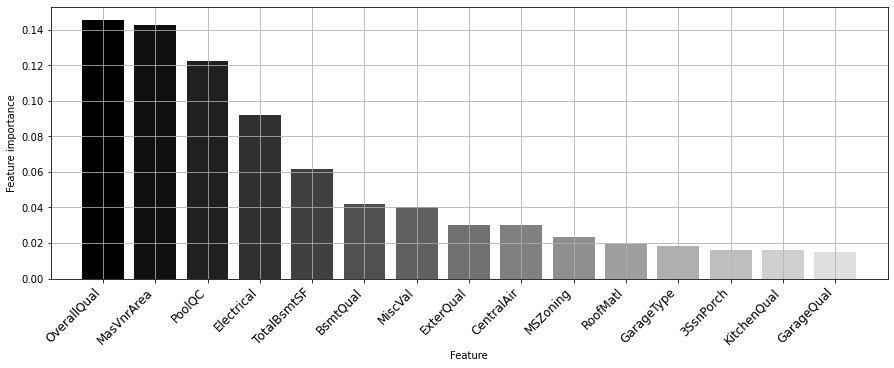

In [22]:
f_list=X.columns
indices = np.argsort(f_i)[::-1]
num_to_plot = 15
feature_indices = indices[:num_to_plot]

plt.figure(figsize=(15,5))
bars = plt.bar(range(num_to_plot), 
               f_i[indices[:num_to_plot]],
color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")

ticks = plt.xticks(range(num_to_plot), 
                   f_list[feature_indices], rotation=45,size=12,horizontalalignment="right")
plt.xlim([-1, num_to_plot])
plt.xlabel('Feature')
plt.ylabel('Feature importance')
plt.grid()
plt.show()

Первые шесть параметров по важности:
    
    OverallQual - оценка общего материала и отделки дома
    MasVnrArea - толщина внешнего слоя кирпича стен дома
    PoolQC - Качество бассейна
    Electrical - Тип системы электричества
    TotalBsmtSF - Площадь подвала
    BsmtQual - Высота подвала